# Specialized Neural Networks

This notebook shows how to use a pipeline of distinct neural networks to predict
secondary structures.

Specialized models are used to:

- Determine the general aspect of the secondary structure
- Determine the precise pairings of the secondary structure
- Estimate the quality of the structure.

In [1]:
import json

import numpy as np
from torch import optim, nn

from diurnal import database, structure, train, transform, visualize, evaluate
from diurnal.models import deep
from diurnal.models.deep import cnn

## Data Preparation

In [2]:
database.download("./data/", "archiveII")
SRC = "./data/archiveII/"  # Input directory containing the CT files.
SIZE = 128  # RNA molecule maximum length (longer ones are filtered out).
DST = f"./data/archiveII_processed_{SIZE}/"  # Output directory of the formatted files.
names = database.format_filenames(SRC, DST + "names.txt", SIZE)
train_names, validation_names, test_names = train.split(
    names, (0.8, 0.1, 0.1)
)

2024-06-06T22:08:30.887890 > INFO Download and install an RNA database.
2024-06-06T22:08:30.917453 >     The dataset `archiveII` is already downloaded at `./data/archiveII`.
2024-06-06T22:08:30.918964 > INFO Extract the filenames from the directory `./data/archiveII/`.


100%|██████████| 3975/3975 [00:13<00:00, 303.93it/s]


2024-06-06T22:08:44.031984 >     Detected 3975 files. Kept 2326 files.
2024-06-06T22:08:44.055633 >     The file `./data/archiveII_processed_128/names.txt` already contains the names.


In [4]:
def format(dst: str, names: list[str]):
    # Primary structures
    database.format_primary_structure(
        names, f"{dst}primary_potential_pairings_onehot.npy",
        SIZE, structure.Primary.to_matrix
    )
    pp_scalar = lambda x, y: structure.Primary.to_matrix(
        x, y, structure.Schemes.IUPAC_PAIRINGS_SCALARS
    )
    database.format_primary_structure(
        names, f"{dst}primary_potential_pairings_scalar.npy", SIZE, pp_scalar
    )
    pp_half_scalar = lambda x, y: transform.halve_matrix(
        structure.Primary.to_matrix(
            x, y, structure.Schemes.IUPAC_PAIRINGS_SCALARS
        )
    )
    database.format_primary_structure(
        names, f"{dst}primary_potential_pairings_half_scalar.npy",
        SIZE, pp_half_scalar
    )
    database.format_primary_structure(
        names, f"{dst}primary_masks.npy", SIZE, structure.Primary.to_mask
    )
    database.format_primary_structure(
        names, f"{dst}primary_onehot.npy",
        SIZE, structure.Primary.to_onehot
    )
    # Secondary structures.
    database.format_secondary_structure(
        names, f"{dst}secondary_bracket.npy", SIZE,
        structure.Secondary.to_onehot
    )
    database.format_secondary_structure(
        names, f"{dst}secondary_contact.npy", SIZE,
        structure.Secondary.to_matrix
    )
    distance_formatter = lambda x, y: structure.Secondary.to_distance_matrix(
        x, y, power=5
    )
    database.format_secondary_structure(
        names, f"{dst}secondary_distance.npy", SIZE, distance_formatter
    )
    half_distance_formatter = lambda x, y: transform.halve_matrix(
        structure.Secondary.to_distance_matrix(x, y, power=5)
    )
    database.format_secondary_structure(
        names, f"{dst}secondary_distance_half.npy",
        SIZE, half_distance_formatter
    )
    half_contact = lambda x, y: transform.halve_matrix(
        structure.Secondary.to_matrix(x, y)
    )
    database.format_secondary_structure(
        names, f"{dst}contact_half.npy", SIZE, half_contact
    )

In [5]:
format(f"{DST}validation/", validation_names)
format(f"{DST}test/", test_names)
format(f"{DST}train/", train_names)

2024-06-06T22:09:15.858685 > INFO Formatting primary structures into `./data/archiveII_processed_128/validation/primary_potential_pairings_onehot.npy`.


2024-06-06T22:09:15.902296 >     The file `./data/archiveII_processed_128/validation/primary_potential_pairings_onehot.npy` already contains the formatted data.
2024-06-06T22:09:15.904305 > INFO Formatting primary structures into `./data/archiveII_processed_128/validation/primary_potential_pairings_scalar.npy`.
2024-06-06T22:09:15.909659 >     The file `./data/archiveII_processed_128/validation/primary_potential_pairings_scalar.npy` already contains the formatted data.
2024-06-06T22:09:15.911721 > INFO Formatting primary structures into `./data/archiveII_processed_128/validation/primary_potential_pairings_half_scalar.npy`.
2024-06-06T22:09:15.919032 >     The file `./data/archiveII_processed_128/validation/primary_potential_pairings_half_scalar.npy` already contains the formatted data.
2024-06-06T22:09:15.920685 > INFO Formatting primary structures into `./data/archiveII_processed_128/validation/primary_masks.npy`.
2024-06-06T22:09:15.965000 >     The file `./data/archiveII_processed_1

In [6]:
def evaluate_model(model, data, is_half: bool = True) -> list[float]:
    f1 = []
    for i in range(len(data["output"])):
        p = model.predict([data["input"][0][i]])
        p *= data["mask"][i]
        p = transform.quantize(p, is_half)
        t = data["target"][i]
        f1.append(evaluate.ContactMatrix.f1(t, p))
    return f1


def check(model, data, index, is_half: bool = True):
    p = model.predict([data["input"][0][index]])
    visualize.heatmap(p)
    p = transform.quantize(p * data["mask"][index], is_half)
    t = data["target"][index]
    visualize.compare_pairings(t, p)
    print(f"F1 score: {evaluate.ContactMatrix.f1(t, p)}")

## Secondary Structure Approximator

In [7]:
def format_data(input, output) -> tuple:
    train_set = {
        "input": (np.load(f"{DST}train/{input}.npy"), ),
        "output": np.load(f"{DST}train/{output}.npy"),
        "names": []
    }
    validation_set = {
        "input": (np.load(f"{DST}validation/{input}.npy"), ),
        "output": np.load(f"{DST}validation/{output}.npy"),
        "names": []
    }
    test_set = {
        "input": (np.load(f"{DST}test/{input}.npy"), ),
        "output": np.load(f"{DST}test/{output}.npy"),
        "target": np.load(f"{DST}test/secondary_contact.npy"),
        "mask": np.load(f"{DST}test/primary_masks.npy"),
        "names": []
    }
    return train_set, validation_set, test_set

In [8]:
def benchmark(input: str, output: str, model: any, is_half: bool):
    t, v, tt = format_data(input, output)
    N_MAX_EPOCHS = 500
    model = deep.NN(
        model=model,
        n_epochs=N_MAX_EPOCHS,
        optimizer=optim.Adam,
        loss_fn=nn.CrossEntropyLoss,
        optimizer_args={"eps": 1e-4},
        loss_fn_args=None,
        use_half=False,
        patience=5,
        verbosity=2,
    )
    model.train(t, v)
    perf = evaluate_model(model, tt, is_half)
    print(np.mean(perf))
    return np.mean(perf)

In [9]:
results = {"half": {}, "full": {}}
for i in range(2, 6):
    #h = benchmark(
    #    "primary_potential_pairings_half_scalar",
    #    "secondary_distance_half",
    #    cnn.UNet2D(SIZE, i),
    #    True
    #)
    f = benchmark(
        "primary_potential_pairings_scalar",
        "secondary_contact",
        cnn.UNet2D(SIZE, i),
        False
    )
    #results["half"][i] = h
    results["full"][i] = f

print(json.dumps(results, indent=4))

2024-06-06T22:09:29.740891 > INFO Training the model with 1860 data points.
2024-06-06T22:09:29.742900 >     Using 232 data points for validation.
2024-06-06T22:09:29.743900 >     Beginning the training.
2024-06-06T22:09:34.006388 >   0 / 500 [                                                  ] Loss: 2.13935  Patience: 5
2024-06-06T22:09:34.627158 >   1 / 500 [                                                  ] Loss: 2.08764  Patience: 5
2024-06-06T22:09:35.251835 >   2 / 500 [                                                  ] Loss: 2.07128  Patience: 5
2024-06-06T22:09:35.916353 >   3 / 500 [                                                  ] Loss: 2.06324  Patience: 5
2024-06-06T22:09:36.568784 >   4 / 500 [                                                  ] Loss: 2.05687  Patience: 5
2024-06-06T22:09:37.211278 >   5 / 500 [                                                  ] Loss: 2.05260  Patience: 5
2024-06-06T22:09:37.851168 >   6 / 500 [                                          

Bilinear, MSELoss:

```
{
    "half": {
        "2": 0.14002722428694112,
        "3": 0.22412354973594434,
        "4": 0.24184887997549157,
        "5": 0.17150800106725816
    },
    "full": {
        "2": 0.25750374166166473,
        "3": 0.19914820824813997,
        "4": 0.15881814373303846,
        "5": 0.2086799383275853
    }
}
```

Nearest, MSELoss:

```
{
    "half": {
        "2": 0.14497220223962232,
        "3": 0.13312604660489435,
        "4": 0.13099839857875786,
        "5": 0.14005017982282
    },
    "full": {
        "2": 0.20398047561596694,
        "3": 0.14966895208886727,
        "4": 0.19901330726510236,
        "5": 0.1312544694459387
    }
}
```

Nearest, CrossEntropy:

```
"full": {
    "2": 0.5233073420260616,
    "3": 0.5351836436974078,
    "4": 0.45687957692505987,
    "5": 0.3744085404443844
}
```

Bilinear, CrossEntropy:

```
"full": {
    "2": 0.5260070533218697,
    "3": 0.5066470320593437,
    "4": 0.4874086688545629,
    "5": 0.5115815666745064
}
```

In [33]:
t, v, tt = format_data(
    "primary_potential_pairings_scalar",
    "secondary_distance",
)
N_MAX_EPOCHS = 500
model = deep.NN(
    model=cnn.UNet2D(SIZE, 2),
    n_epochs=N_MAX_EPOCHS,
    optimizer=optim.Adam,
    loss_fn=nn.CrossEntropyLoss,
    optimizer_args={"eps": 1e-4},
    loss_fn_args=None,
    use_half=False,
    patience=5,
    verbosity=2,
)
model.train(t, v)

2024-06-06T21:53:59.543039 > INFO Training the model with 1860 data points.
2024-06-06T21:53:59.545389 >     Using 232 data points for validation.
2024-06-06T21:53:59.546400 >     Beginning the training.
2024-06-06T21:54:00.451080 >   0 / 500 [                                                  ] Loss: 228.47393  Patience: 5
2024-06-06T21:54:01.120202 >   1 / 500 [                                                  ] Loss: 228.47140  Patience: 5
2024-06-06T21:54:01.751008 >   2 / 500 [                                                  ] Loss: 228.47031  Patience: 5
2024-06-06T21:54:02.379364 >   3 / 500 [                                                  ] Loss: 228.46906  Patience: 5
2024-06-06T21:54:03.000401 >   4 / 500 [                                                  ] Loss: 228.46768  Patience: 5
2024-06-06T21:54:03.625136 >   5 / 500 [                                                  ] Loss: 228.39013  Patience: 5
2024-06-06T21:54:04.240385 >   6 / 500 [                              

[0.0, 0.15909090638160706, 0.06976743787527084, 0.04651162773370743, 0.0, 0.0357142873108387, 0.0, 0.10526316612958908, 0.0, 0.27586203813552856, 0.1090909093618393, 0.03508772328495979, 0.145454540848732, 0.11363636702299118, 0.12195121496915817, 0.13698630034923553, 0.18390806019306183, 0.25287356972694397, 0.07407408207654953, 0.3333333432674408, 0.16091954708099365, 0.0, 0.17910447716712952, 0.1204819306731224, 0.07058823853731155, 0.08888889104127884, 0.17582418024539948, 0.09302326291799545, 0.07547170668840408, 0.25, 0.10389610379934311, 0.146341472864151, 0.037037041038274765, 0.2068965584039688, 0.21978022158145905, 0.0, 0.18867924809455872, 0.1428571492433548, 0.2921348214149475, 0.1599999964237213, 0.06741572916507721, 0.1600000113248825, 0.17777776718139648, 0.1927710771560669, 0.0, 0.1428571492433548, 0.06896551698446274, 0.03448275476694107, 0.0845070406794548, 0.08571429550647736, 0.1666666716337204, 0.0416666679084301, 0.04494382441043854, 0.07500000298023224, 0.0597014

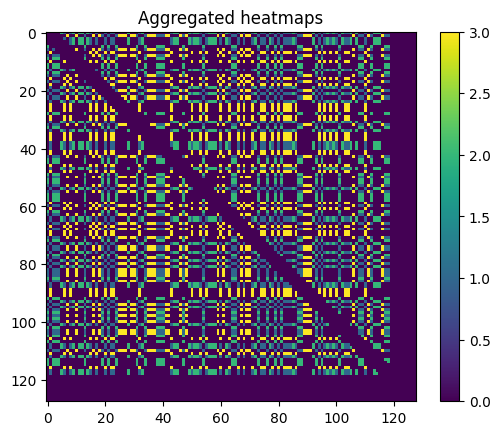

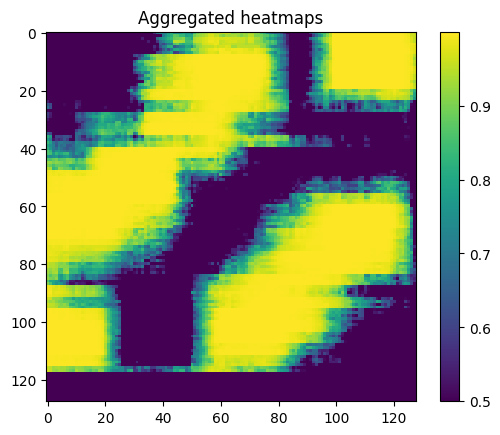

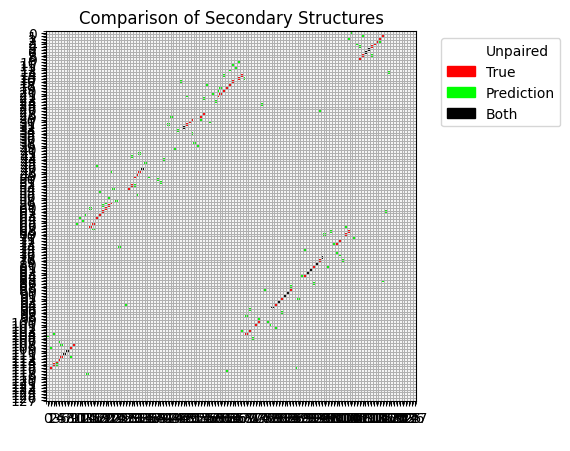

F1 score: 0.15909090638160706


In [34]:
p = evaluate_model(model, tt, False)
print(p)
print(np.mean(p))
visualize.heatmap(tt["input"][0][1])
check(model, tt, 1)

In [10]:
t, v, tt = format_data(
    "primary_potential_pairings_scalar",
    "secondary_contact",
)
N_MAX_EPOCHS = 100
model = deep.NN(
    model=cnn.UNet2D(SIZE, 4),
    n_epochs=N_MAX_EPOCHS,
    optimizer=optim.Adam,
    loss_fn=nn.CrossEntropyLoss,
    optimizer_args={"eps": 1e-4},
    loss_fn_args=None,
    use_half=False,
    patience=5,
    verbosity=2,
)
model.train(t, v)

2024-06-06T22:14:02.229270 > INFO Training the model with 1860 data points.
2024-06-06T22:14:02.233276 >     Using 232 data points for validation.
2024-06-06T22:14:02.235285 >     Beginning the training.
2024-06-06T22:14:03.486913 >   0 / 100 [                                                  ] Loss: 2.13746  Patience: 5
2024-06-06T22:14:04.415386 >   1 / 100 [                                                  ] Loss: 2.08912  Patience: 5
2024-06-06T22:14:05.375212 >   2 / 100 [=                                                 ] Loss: 2.07293  Patience: 5
2024-06-06T22:14:06.258274 >   3 / 100 [=                                                 ] Loss: 2.06389  Patience: 5
2024-06-06T22:14:07.181778 >   4 / 100 [==                                                ] Loss: 2.05999  Patience: 5
2024-06-06T22:14:08.087056 >   5 / 100 [==                                                ] Loss: 2.05295  Patience: 5
2024-06-06T22:14:09.006990 >   6 / 100 [===                                       

[0.46666666865348816, 0.5777777433395386, 0.6744186282157898, 0.4597701132297516, 0.10256411135196686, 0.29032257199287415, 0.5185185670852661, 0.5517241358757019, 0.35555553436279297, 0.6363636255264282, 0.48275864124298096, 0.07017544656991959, 0.4482758343219757, 0.6304348111152649, 0.7529411911964417, 0.13513512909412384, 0.6590908765792847, 0.48275861144065857, 0.6071428656578064, 0.6190476417541504, 0.6153846383094788, 0.13333334028720856, 0.29411762952804565, 0.5714285969734192, 0.27586206793785095, 0.6666666865348816, 0.5054945349693298, 0.7441861033439636, 0.444444477558136, 0.5714285969734192, 0.2750000059604645, 0.6206896901130676, 0.222222238779068, 0.5747126340866089, 0.7096774578094482, 0.11428572237491608, 0.5517241358757019, 0.47191011905670166, 0.7045454382896423, 0.3333333134651184, 0.5977011919021606, 0.3544303774833679, 0.5111110806465149, 0.6896551251411438, 0.5614035129547119, 0.651685357093811, 0.2068965584039688, 0.06896550953388214, 0.29333335161209106, 0.30555

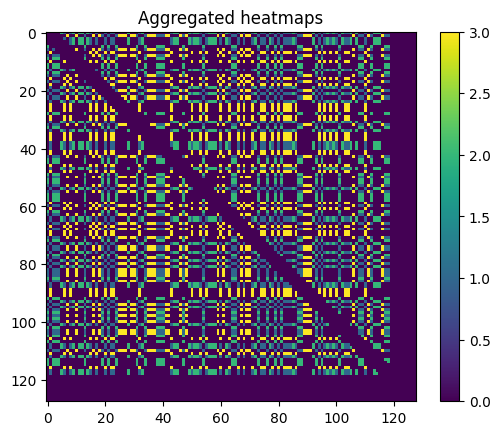

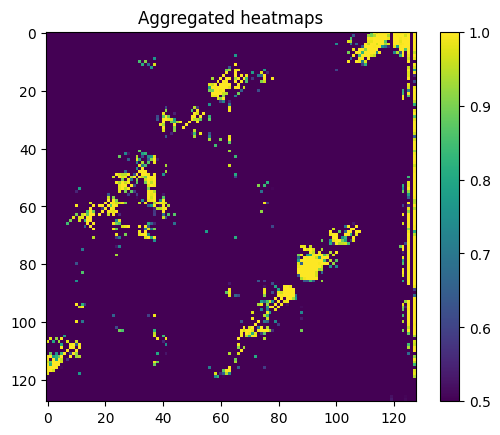

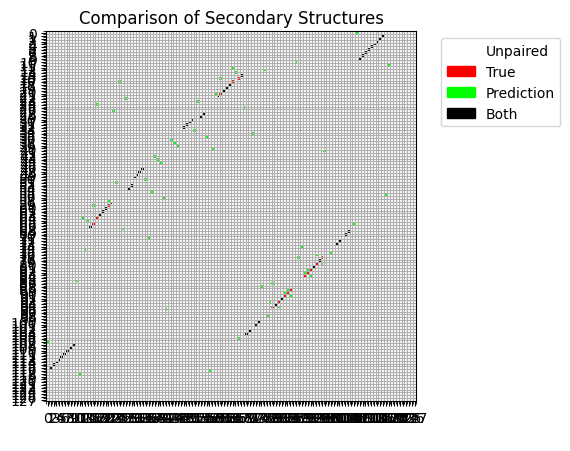

F1 score: 0.5777777433395386


In [11]:
p = evaluate_model(model, tt, False)
print(p)
print(np.mean(p))
visualize.heatmap(tt["input"][0][1])
check(model, tt, 1)

## Low-Pass Filter

In [17]:
import scipy.ndimage


class FilteredModel():
    def __init__(self, model):
        self.model = model

    def predict(self, ppm, mask):
        p = self.model.predict(ppm)
        p *= mask
        p = transform.quantize(p, False)
        tmp = scipy.ndimage.convolve(p, np.ones((3,3)), mode='constant')
        out = np.logical_and(tmp >= 2, p).astype(np.float32)
        return out

low_pass = FilteredModel(model)


def evaluate_filtered_model(model, data, is_half: bool = True) -> list[float]:
    f1 = []
    for i in range(len(data["output"])):
        p = model.predict([data["input"][0][i]], data["mask"][i])
        t = data["target"][i]
        f1.append(evaluate.ContactMatrix.f1(t, p))
    return f1


def check(model, data, index, is_half: bool = True):
    p = model.predict([data["input"][0][index]], data["mask"][index])
    visualize.heatmap(p)
    t = data["target"][index]
    visualize.compare_pairings(t, p)
    print(f"F1 score: {evaluate.ContactMatrix.f1(t, p)}")

[0.6829268336296082, 0.7384615540504456, 0.8358209133148193, 0.5161290168762207, 0.0, 0.34285712242126465, 0.6666666865348816, 0.6976744532585144, 0.4444444179534912, 0.746268630027771, 0.6341463327407837, 0.06060606241226196, 0.555555522441864, 0.7887324094772339, 0.9275362491607666, 0.10256410390138626, 0.8235294222831726, 0.6153846383094788, 0.8095238208770752, 0.7352941036224365, 0.7384615540504456, 0.2666666507720947, 0.4000000059604645, 0.7272728085517883, 0.290909081697464, 0.8615384697914124, 0.6301369667053223, 0.9014084935188293, 0.550000011920929, 0.75, 0.2222222089767456, 0.7384616136550903, 0.21739129722118378, 0.688524603843689, 0.8571428656578064, 0.21052633225917816, 0.6666666865348816, 0.5333333015441895, 0.8695652484893799, 0.5333333611488342, 0.6764705777168274, 0.41860464215278625, 0.7076922655105591, 0.8923077583312988, 0.7272727489471436, 0.8358209133148193, 0.1818181872367859, 0.05882352963089943, 0.3913043737411499, 0.30434781312942505, 0.3396226763725281, 0.0, 

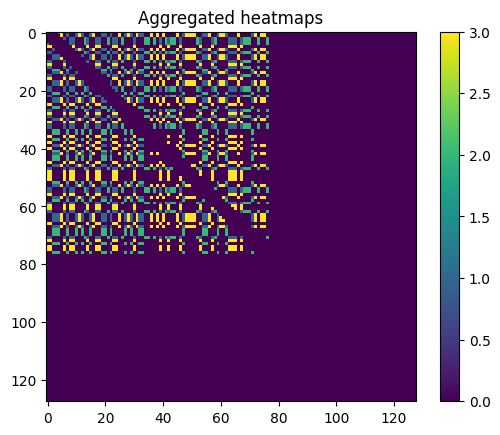

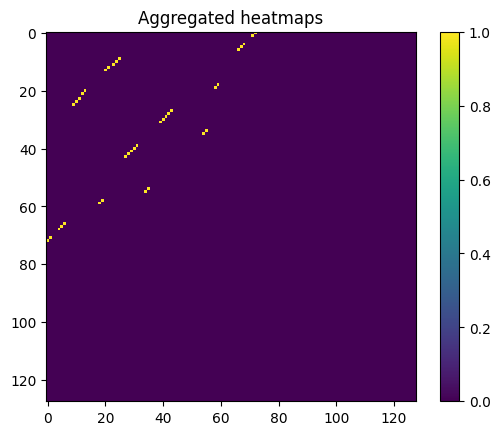

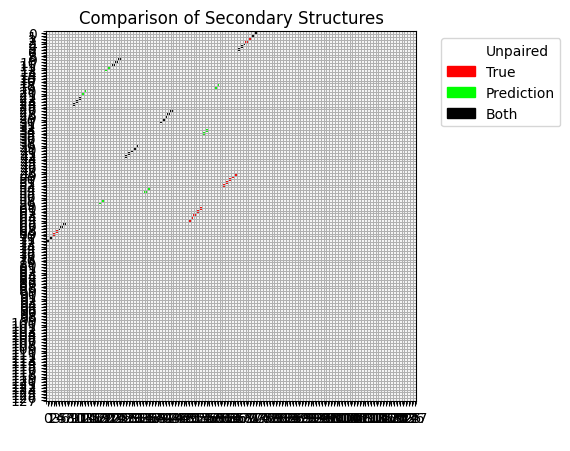

F1 score: 0.6666666865348816


In [23]:
p = evaluate_filtered_model(low_pass, tt, False)
print(p)
print(np.mean(p))
visualize.heatmap(tt["input"][0][6])
check(low_pass, tt, 6)

## Secondary Structure Refiner

Blocks:

1. Global structure estimator - GSE (Autoencoder, UNet)
2. Contraint unit - CU (mask multiplication)
3. Monomialization unit - MU (function)
4. Low-pass filter - LPF (threshold on convoluted sum, NN)
5. Local structure refiner - LSR (NN)

Acyclic Graphs:

A. GSE -> CU -> MU -> LPF -> LSR
B. GSE -> CU -> LPF -> LSR -> MU
C. GSE -> CU -> LPF -> MU -> LSR -> MU